In [133]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

pd.set_option('display.max_columns', None)

In [134]:
transactional_data = pd.read_csv('../../data/interim/transactional_data_clean.csv')
exams_data = pd.read_csv('../../data/interim/exams_data_clean.csv')
geocode_data = pd.read_csv('../../data/interim/geocode_data_clean.csv')
economic_data = pd.read_csv('../../data/interim/economic_data_clean.csv')
demographic_data = pd.read_csv('../../data/interim/demographic_data_clean.csv')

In [135]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

---

### Hipótese
ZCTAs com maior população tendem a gerar um volume maior de exames e, consequentemente, maior receita.

In [136]:
# 1. Merge dos dados transacionais com geocode_data para obter o zipcode (ZCTA)
trans_geo = pd.merge(transactional_data, geocode_data[['lab__id', 'zipcode']], 
                     on='lab__id', how='left')

In [137]:
# 2. Agregação dos dados transacionais por zipcode
agg_data = trans_geo.groupby('zipcode').agg(
    volume=('service__id', 'count'),
    revenue=('testing__cost', 'sum')
).reset_index()

In [138]:
# 3. Merge dos dados agregados com demographic_data para trazer a população total
df_merged = pd.merge(agg_data, demographic_data[['zipcode', 'total_population']], 
                     on='zipcode', how='inner')

In [139]:
# Exibindo dados combinados
df_merged.head()

,zipcode,volume,revenue,total_population
0,1605.0,12658,323954.36,28533
1,1605.0,12658,323954.36,28533
2,1605.0,12658,323954.36,28533
3,1605.0,12658,323954.36,28533
4,1605.0,12658,323954.36,28533


In [140]:
# Removendo os duplicados
df_merged = df_merged.drop_duplicates()

df_merged.head()

,zipcode,volume,revenue,total_population
0,1605.0,12658,323954.36,28533
13,1606.0,8407,313512.08,19896
26,1701.0,17993,930395.16,32590
39,1702.0,20099,505300.80,39799
52,1840.0,33938,1263382.62,5573


In [141]:
# 4. Cálculo da Correlação de Pearson

# Correlação entre total_population e volume de exames
corr_population_volume, p_value_volume = stats.pearsonr(df_merged['total_population'], df_merged['volume'])

# Correlação entre total_population e receita
corr_population_revenue, p_value_revenue = stats.pearsonr(df_merged['total_population'], df_merged['revenue'])

In [142]:
print("\nCorrelação entre total_population e volume de exames:")
print(f"Coeficiente: {corr_population_volume:.3f}, p-valor: {p_value_volume:.3e}")

print("\nCorrelação entre total_population e receita:")
print(f"Coeficiente: {corr_population_revenue:.3f}, p-valor: {p_value_revenue:.3e}")


Correlação entre total_population e volume de exames:
Coeficiente: 0.734, p-valor: 1.805e-18

Correlação entre total_population e receita:
Coeficiente: 0.677, p-valor: 5.499e-15


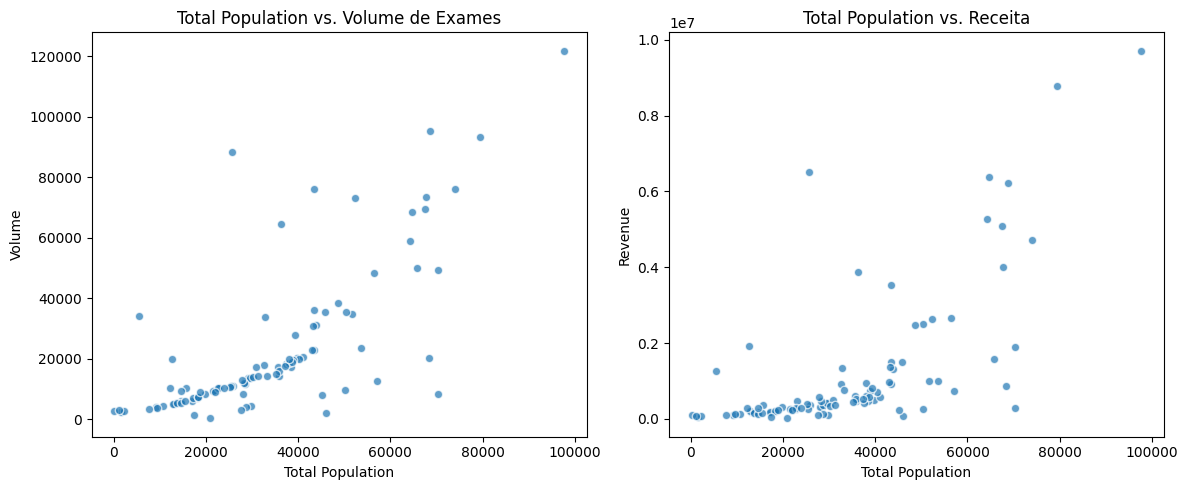

In [143]:
# 5. Visualização dos Resultados
plt.figure(figsize=(12, 5))

# Gráfico de dispersão: População x Volume de Exames
plt.subplot(1, 2, 1)
plt.scatter(df_merged['total_population'], df_merged['volume'], alpha=0.7, edgecolor='w')
plt.title('Total Population vs. Volume de Exames')
plt.xlabel('Total Population')
plt.ylabel('Volume')

# Gráfico de dispersão: População x Receita
plt.subplot(1, 2, 2)
plt.scatter(df_merged['total_population'], df_merged['revenue'], alpha=0.7, edgecolor='w')
plt.title('Total Population vs. Receita')
plt.xlabel('Total Population')
plt.ylabel('Revenue')

plt.tight_layout()
plt.show()

### Conclusão

Analisando os resultados, é possível confirmar a hipótese de que ZCTAs com maior população tendem a gerar maior volume de exames e receita. Os coeficientes de correlação são robustos: 0.734 para volume de exames e 0.677 para receita, ambos com p-value extremamente baixos (1.805e-18 e 5.499e-15, respectivamente), indicando alta significância estatística.
Os gráficos mostram uma clara tendência positiva, com alguns insights adicionais:

1. A correlação é forte, mas não perfeita, sugerindo que outros fatores além da população influenciam o volume de exames e receita.

2. Existe uma concentração maior de ZCTAs com populações menores (abaixo de 40.000), mas os outliers com populações maiores apresentam volumes e receitas significativamente mais altos.

3. Há alguns ZCTAs que fogem do padrão esperado, gerando volumes ou receitas desproporcionais ao tamanho de sua população, merecendo investigação adicional.

4. A dispersão parece aumentar com o tamanho da população, indicando maior variabilidade nos mercados maiores.

Para a estratégia de expansão, população deve ser considerada como um fator primário, mas não único

---

### Hipótese
Determinadas faixas etárias (por exemplo, idosos) podem demandar mais exames diagnósticos.

In [144]:
# 1. Pré-processamento dos dados
# Convertendo campos de data para datetime
transactional_data['date_of_birth'] = pd.to_datetime(transactional_data['date_of_birth'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
transactional_data['date_of_service'] = pd.to_datetime(transactional_data['date_of_service'], format='%Y-%m-%d', errors='coerce')

# Calculando a idade do paciente no momento do exame
transactional_data['age_at_service'] = (transactional_data['date_of_service'] - transactional_data['date_of_birth']).dt.days / 365.25

# Criando faixas etárias para análise
age_bins = [0, 5, 9, 14, 19, 24, 34, 44, 54, 59, 64, 74, 84, 120]
age_labels = ['0-5', '6-9', '10-14', '15-19', '20-24', '25-34', '35-44', '45-54', '55-59', '60-64', '65-74', '75-84', '85+']
transactional_data['age_group'] = pd.cut(transactional_data['age_at_service'], bins=age_bins, labels=age_labels)

In [145]:
# 2. Análise do volume de exames por faixa etária
exams_by_age = transactional_data.groupby('age_group').size().reset_index(name='exam_count')
exams_by_age['percentage'] = (exams_by_age['exam_count'] / exams_by_age['exam_count'].sum()) * 100

# Agrupando população por faixas etárias criadas
demo_age_groups = demographic_data['age_group'].unique()

# Mapeamento entre os grupos demográficos e as faixas etárias
demographic_mapping = {
    '< 5 Years': '0-5',
    '5 - 9 Years': '6-9',
    '10 - 14 Years': '10-14',
    '15 - 19 Years': '15-19',
    '20 - 24 Years': '20-24',
    '25 - 34 Years': '25-34',
    '35 - 44 Years': '35-44',
    '45 - 54 Years': '45-54',
    '55 - 59 Years': '55-59',
    '60 - 64 Years': '60-64',
    '65 - 74 Years': '65-74',
    '75 - 84 Years': '75-84',
    '85 Years >=': '85+'
}

In [ ]:
# Aplicando o mapeamento
demographic_data['mapped_age_group'] = demographic_data['age_group'].map(demographic_mapping)

# Agrupando a população por nossas faixas etárias
population_by_age = demographic_data.groupby('mapped_age_group')['group_population'].sum().reset_index()
population_by_age['percentage'] = (population_by_age['group_population'] / population_by_age['group_population'].sum()) * 100

# Juntando os dados para comparação
comparison_df = pd.merge(exams_by_age, population_by_age, left_on='age_group', right_on='mapped_age_group', how='left')
comparison_df.rename(columns={'percentage_x': 'exams_percentage', 'percentage_y': 'population_percentage'}, inplace=True)

# Calculando a taxa de exames relativa à população
comparison_df['exams_per_capita'] = comparison_df['exam_count'] / comparison_df['group_population']
comparison_df['demand_index'] = comparison_df['exams_percentage'] / comparison_df['population_percentage']

In [147]:
# 3. Análise do custo médio dos exames por faixa etária
cost_by_age = transactional_data.groupby('age_group')['testing__cost'].agg(['mean', 'median', 'sum']).reset_index()
cost_by_age.columns = ['age_group', 'mean_cost', 'median_cost', 'total_cost']
cost_by_age['cost_percentage'] = (cost_by_age['total_cost'] / cost_by_age['total_cost'].sum()) * 100

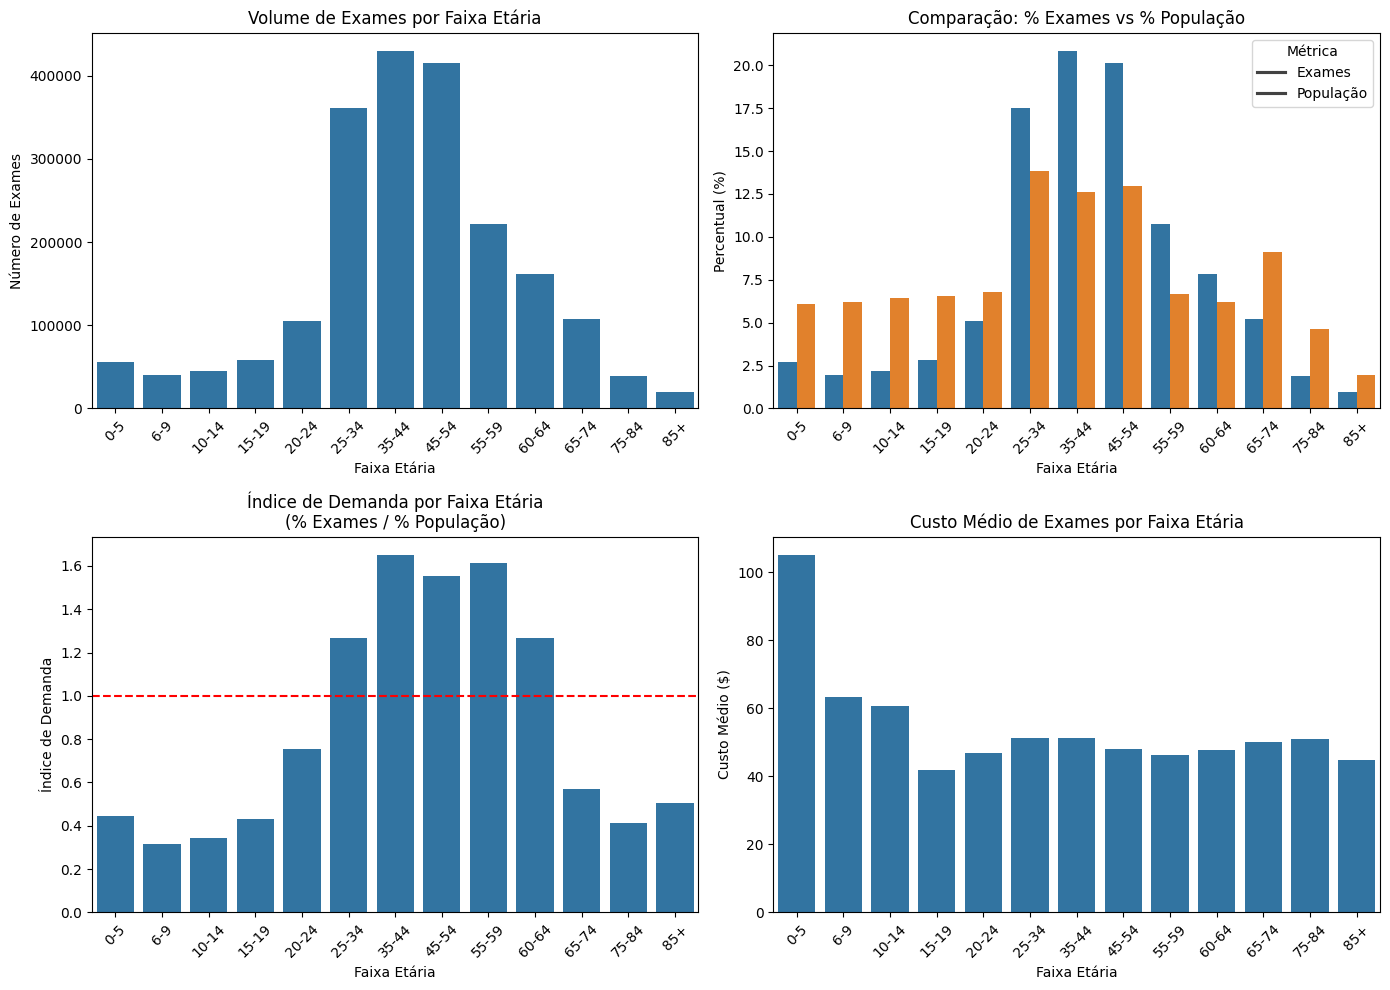

In [148]:
# 4. Visualizações
plt.figure(figsize=(14, 10))

# 4.1 Volume de exames por faixa etária
plt.subplot(2, 2, 1)
sns.barplot(x='age_group', y='exam_count', data=exams_by_age)
plt.title('Volume de Exames por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Número de Exames')
plt.xticks(rotation=45)

# 4.2 Comparação entre percentual de exames e percentual da população
plt.subplot(2, 2, 2)
comparison_df_melted = pd.melt(comparison_df, id_vars=['age_group'],
                              value_vars=['exams_percentage', 'population_percentage'],
                              var_name='Metric', value_name='Percentage')
sns.barplot(x='age_group', y='Percentage', hue='Metric', data=comparison_df_melted)
plt.title('Comparação: % Exames vs % População')
plt.xlabel('Faixa Etária')
plt.ylabel('Percentual (%)')
plt.xticks(rotation=45)
plt.legend(title='Métrica', labels=['Exames', 'População'])

# 4.3 Índice de demanda (exames per capita normalizado)
plt.subplot(2, 2, 3)
sns.barplot(x='age_group', y='demand_index', data=comparison_df)
plt.title('Índice de Demanda por Faixa Etária\n(% Exames / % População)')
plt.xlabel('Faixa Etária')
plt.ylabel('Índice de Demanda')
plt.xticks(rotation=45)
plt.axhline(y=1, color='r', linestyle='--')  # Linha de referência onde % exames = % população

# 4.4 Custo médio por faixa etária
plt.subplot(2, 2, 4)
sns.barplot(x='age_group', y='mean_cost', data=cost_by_age)
plt.title('Custo Médio de Exames por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Custo Médio ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [149]:
# 5. Análise estatística para verificar se há diferença significativa entre as faixas etárias
print("\n===== Testes Estatísticos =====")

# ANOVA para testar se há diferença significativa no número de exames por paciente entre faixas etárias
exams_per_patient = transactional_data.groupby(['patient__id', 'age_group']).size().reset_index(name='exam_count')

# Lista para armazenar os dados de cada grupo para ANOVA
age_groups_data = [group['exam_count'].values for name, group in exams_per_patient.groupby('age_group')]

# Realizando o teste ANOVA
f_stat, p_value = stats.f_oneway(*age_groups_data)
print(f"ANOVA - Diferença no número de exames por paciente entre faixas etárias:")
print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.10f}")
print(f"{'Diferença estatisticamente significativa' if p_value < 0.05 else 'Não há diferença estatisticamente significativa'}")


===== Testes Estatísticos =====
ANOVA - Diferença no número de exames por paciente entre faixas etárias:
F-statistic: 9540.0360, p-value: 0.0000000000
Diferença estatisticamente significativa


In [150]:
# 6. Resumo dos resultados
print("\n===== Resumo da Análise =====")
print("\nVolume de exames por faixa etária:")
print(exams_by_age.to_string(index=False))

print("\nComparação entre % de exames e % da população:")
print(comparison_df[['age_group', 'exams_percentage', 'population_percentage', 'demand_index']].to_string(index=False))

print("\nCusto médio e total por faixa etária:")
print(cost_by_age[['age_group', 'mean_cost', 'total_cost', 'cost_percentage']].to_string(index=False))


===== Resumo da Análise =====

Volume de exames por faixa etária:
age_group  exam_count  percentage
      0-5       55856    2.708172
      6-9       40087    1.943614
    10-14       45347    2.198645
    15-19       58294    2.826378
    20-24      105553    5.117726
    25-34      361711   17.537520
    35-44      430043   20.850590
    45-54      415162   20.129086
    55-59      221901   10.758847
    60-64      161657    7.837923
    65-74      107372    5.205920
    75-84       39367    1.908705
      85+       20148    0.976874

Comparação entre % de exames e % da população:
age_group  exams_percentage  population_percentage  demand_index
      0-5          2.708172               6.070954      0.446087
      6-9          1.943614               6.199455      0.313514
    10-14          2.198645               6.441603      0.341319
    15-19          2.826378               6.533200      0.432618
    20-24          5.117726               6.781367      0.754675
    25-34         1

### Conclusão

A análise da hipótese de que determinadas faixas etárias, como os idosos, demandariam mais exames diagnósticos revelou resultados estatisticamente significativos (ANOVA F=9540.04, p<0.0000000000), comprovando diferenças marcantes no comportamento de utilização dos serviços diagnósticos conforme a idade, porém não como os idosos especificados pela hipótese.

- **Volume Absoluto de Exames:**  
  As faixas etárias de 35-44 e 45-54 apresentam os maiores volumes de exames, contribuindo com 20,85% e 20,13% do total, respectivamente, seguidas pela faixa 25-34 (17,54%) e 55-59 (10,76%). Em contrapartida, os grupos considerados idosos (65-74: 5,21%, 75-84: 1,91% e 85+: 0,98%) têm uma representatividade menor no volume total de exames, o que contradiz parcialmente a hipótese inicial de que os idosos demandariam mais exames.

- **Índice de Demanda em Relação à População:**  
  Ao comparar o percentual de exames com o percentual da população, observa-se que as faixas 25-34 (índice=1.27), 35-44 (índice=1.65), 45-54 (índice=1.55) e 55-59 (índice=1.61) demandam exames em proporção superior à sua participação populacional. Já os grupos de crianças (0-5, 6-9, 10-14 e 15-19) e idosos (65-74, 75-84 e 85+) apresentam índices bem abaixo de 1.

- **Análise de Custos:**  
  Embora a faixa etária de 0-5 anos represente apenas 2,71% do total de exames, ela destaca-se pelo custo médio elevado ($105,14), correspondendo a 5,58% do custo total, o que pode indicar a complexidade ou especialização dos exames nesta faixa. Por outro lado, as faixas de maior volume (25-34, 35-44 e 45-54) apresentam custos médios próximos (entre $47,89 e $51,31) e concentram a maior parte dos gastos totais (17,61%, 20,95% e 18,88%, respectivamente).

Esses resultados sugerem que a maior demanda por exames não está concentrada apenas nos idosos, mas principalmente em adultos de meia-idade, especialmente nas faixas de 25 a 59 anos. Assim, para o plano de expansão, recomenda-se priorizar regiões com maior concentração desses grupos, potencializando o atendimento ao volume elevado de exames e a gestão dos custos associados, sem desconsiderar a necessidade de atenção aos grupos com exames de custo elevado, como o de crianças pequenas.


---

### Hipótese
ZCTAs com maior poder aquisitivo podem gerar maior receita e até mesmo ter demanda por exames de maior valor agregado.